In [1]:
%matplotlib inline
from matplotlib import pyplot as plt
from matminer.featurizers.base import MultipleFeaturizer, StackedFeaturizer
from matminer.featurizers import composition as cf
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.model_selection import GridSearchCV, ShuffleSplit, LeaveOneGroupOut, cross_val_score, learning_curve, KFold
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import Imputer, LabelEncoder
from sklearn.metrics import roc_curve, auc, r2_score, make_scorer
from sklearn import metrics
from pymatgen import Composition
import pickle as pkl
import pandas as pd
import numpy as np
import gzip
import os
import copy

In [2]:
def featCleanImpute(Y):
    ''' Convert inf to NaN in feature array, in place
    
    Args: 
        Y, feature array, list of ndarray (#samples x #features)
    Returns:
        None
    '''
    # Clean inf values
    for i in range(len(Y)):
        for j in range(len(Y[i])):
            if Y[i][j] == np.inf:
                Y[i][j] = np.nan
            else:
                Y[i][j] = Y[i][j]
                
    # Impute nan values
    imp = Imputer(missing_values='NaN', axis=0, strategy='mean', copy=False)
    imp2 = Imputer(missing_values='NaN', axis=1, strategy='mean', copy=False)

    imp.fit(Y)
    imp.transform(Y)
    imp2.fit(Y)
    imp.transform(Y)
    

In [3]:
def genStatsDF(dfOrig):
    '''
    Generates a new dataframe that merges duplicate entries, while supplying avg/std/no.

    input: DataFrame with 2 columns, first is composition, second is property
    output: Datafrme with 4 columns

    '''
    yDcopy = dfOrig.copy()
    (col1, col2) = dfOrig.columns

    redList = []
    cnt=0
    while ~yDcopy.empty and cnt < len(yDcopy):
        compTemp = yDcopy[col1][0]
        
        # difference must be below atol+rtol*mean.  
        dupes = yDcopy[ [x.almost_equals(compTemp) for x in yDcopy[col1]] ]

        tempDict = {col1: compTemp, col2+'_avg': dupes[col2].mean(), 
                    col2+'_std': dupes[col2].std(), 'numSamp': len(dupes)}

        redList.append(tempDict)

        #remove processed entries
        yDcopy.drop(index=list(dupes.index), inplace=True)
        yDcopy.reset_index(drop=True, inplace=True)
        cnt+=1

    reducedDF = pd.DataFrame(redList)
    return reducedDF

# Import and Format datasets

In [4]:
elastProp_SLAC = pd.read_excel('datasets/Mechnical properties analysis v33_Pruned.xlsx')
rawCopy = elastProp_SLAC.copy()
len(rawCopy)

2174

In [5]:
elastProp_SLAC.head()

,Compositions,Sample,Conditions,Tensile strength (MPa),Error,"Yeild strength, σy (MPa)",Error,Elongation (%),"Compressive fracture strength, σf (MPa)",Error.1,...,Vd (%),Strain hardening rate,ρ (g/cm3),"Stress Intensity, Kc",G/K,θd,"Energy of fracture,Gc",Glasses,"Diameter, mm",Reference2
0,Zr55Al10Ni5Cu30,Zr-based,NaN,1840,NaN,NaN,NaN,2,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,BMG,NaN,"B. Guennec et al, Intermetallics 92 (2018) 72–78"
1,Zr61Ti2Cu25Al12,Zr-based,NaN,1600,NaN,NaN,NaN,NaN,1688,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,BMG,NaN,"Z-Q Song et al, Acta Materialia 99 (2015) 165–175"
2,Zr56Co24Ag4Al16,Zr-based,(electric charge 100 Ag),2284,63,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,BMG,NaN,"M. Mohammadi Rahvard et al, Journal of Non-Cry..."
3,Zr56Co24Ag4Al16,Zr-based,(electric charge 90 Ag),2197,48,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,BMG,NaN,"M. Mohammadi Rahvard et al, Journal of Non-Cry..."
4,Al20Co25Zr55,Al-based,NaN,2050,NaN,NaN,NaN,2.1,2200,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,BMG,NaN,"M. Mohammadi Rahvard et al, Journal of Non-Cry..."


In [6]:
elastProp_SLAC.rename(index=str, columns={'θd':'theta_d', 'ρ (g/cm3)':'density (g/cm3)', 
                                          'Yeild strength, σy (MPa)':'Yeild strength (MPa)', 
                                         'Compressive fracture strength, σf (MPa)': 'Compressive fracture strength (MPa)'},inplace=True)
#elastProp_SLAC.columns

In [7]:
dfSLAC = elastProp_SLAC

In [8]:
def makeComp(x):
    '''Apply Composition() constructor to string x
       Return: Composition object, or 0 if not parse-able'''
    try:
        return Composition(x)
    except:
        print(x)
        return 0

In [9]:
# prints out compositions that cannot be converted into Composition objects
dfSLAC['comp'] = dfSLAC['Compositions'].apply(makeComp)

Mg60Ca30−xTixY10
Mg60Li5Cu25−xZnx (Y, Gd)10
Mg65−xLixCu25Znx (Y, Gd)10
(CaCu)100xMgx
La57.6Al17.5(Cu,Ni)24.9
La64Al14 (Cu = Ni)22
Fused quartz
Amorphous carbon
Microcrystal glass
Breakaway glass
Water-white glass
Window glass
Float glass
Ti-glass
Borosilicate glass
B2O3 glass
Glassy sulfur
Amorphous Se
Fused quartz
window glass (SiO2)
∥Fe70Mo5Ni5∣P12.5∥C5B2.5∣
Toughened glass (SiO2)
Amorphous carbon
Vit1
Float glass
Ti-glass
Window glass
Water-white glass
Fused quartz
Microcrystal glass
Borosilicate glass
Carbon glass
Mo52Cr14Fel4P12B8
Fused silica
Window glass
Toughened glass
Sn 99.9%
(Zr54Al17C029)100-0Ta0
316L SS
Ti-6Al-4V
Cortical bone
Vitreloy 105
FC20+0.4 wt.% B
La74Al14(Cu,Ni)12
300 M Steel
D6AC Steel 
Ti-6Al-4V 
2090-T81 Al–Li 


Remove entries where composition was unable to be read

In [10]:
dfSLAC = dfSLAC[dfSLAC['comp']!=0]
dfSLAC.reset_index(drop=True, inplace=True)
print('{} entries remaining'.format(len(dfSLAC)))

2126 entries remaining


In [11]:
cols = dfSLAC.columns.tolist()
dfSLAC = dfSLAC[cols[-1:] + cols[:-1]]
print("moved 'comp' to first column")

moved 'comp' to first column


In [12]:
len(dfSLAC['comp']!=0)

2126

In [13]:
def redComp(x):
    try: 
        return Composition(x.reduced_formula)
    except: 
        print(x)
        return 0
    
dfSLAC['comp'] = dfSLAC['comp'].apply(redComp)
dfSLAC = dfSLAC[dfSLAC['comp']!=0]
dfSLAC.reset_index(drop=True, inplace=True)
print('{} entries remaining'.format(len(dfSLAC)))

C:\Users\Hikaru\Anaconda2\envs\py36\lib\site-packages\pymatgen\core\periodic_table.py:423: UserWarning:

No electronegativity for Ar. Setting to NaN. This has no physical meaning, and is mainly done to avoid errors caused by the code expecting a float.




2125 entries remaining


In [14]:
dfSLAC.head()

,comp,Compositions,Sample,Conditions,Tensile strength (MPa),Error,Yeild strength (MPa),Error,Elongation (%),Compressive fracture strength (MPa),...,Vd (%),Strain hardening rate,density (g/cm3),"Stress Intensity, Kc",G/K,theta_d,"Energy of fracture,Gc",Glasses,"Diameter, mm",Reference2
0,"(Zr, Al, Cu, Ni)",Zr55Al10Ni5Cu30,Zr-based,NaN,1840,NaN,NaN,NaN,2,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,BMG,NaN,"B. Guennec et al, Intermetallics 92 (2018) 72–78"
1,"(Zr, Ti, Al, Cu)",Zr61Ti2Cu25Al12,Zr-based,NaN,1600,NaN,NaN,NaN,NaN,1688,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,BMG,NaN,"Z-Q Song et al, Acta Materialia 99 (2015) 165–175"
2,"(Zr, Al, Co, Ag)",Zr56Co24Ag4Al16,Zr-based,(electric charge 100 Ag),2284,63,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,BMG,NaN,"M. Mohammadi Rahvard et al, Journal of Non-Cry..."
3,"(Zr, Al, Co, Ag)",Zr56Co24Ag4Al16,Zr-based,(electric charge 90 Ag),2197,48,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,BMG,NaN,"M. Mohammadi Rahvard et al, Journal of Non-Cry..."
4,"(Zr, Al, Co)",Al20Co25Zr55,Al-based,NaN,2050,NaN,NaN,NaN,2.1,2200,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,BMG,NaN,"M. Mohammadi Rahvard et al, Journal of Non-Cry..."


Import NREL dataset

In [15]:
# cell about Composition.almost_equal() method experimentation was here
# Note that an unreduced chemical formula is not equal in composition

# Build individual datasets

### Generate, clean feature set

In [16]:
base_featurizer = MultipleFeaturizer([cf.Stoichiometry(), cf.ElementProperty.from_preset("magpie"),
                                 cf.ValenceOrbital(props=['avg']), cf.IonProperty(fast=True),
                                cf.YangSolidSolution(), cf.AtomicPackingEfficiency()])

### Young's Modulus dataset 
Isolate Youngs Modulus, Composition.
Build Features

In [17]:
# Separate Data into new frame
youngsSLAC = pd.DataFrame()
youngsSLAC['comp'] = dfSLAC['comp']
youngsSLAC['E'] = dfSLAC['Young’s  Modulus, E (GPa)']

# Drop missing entries 
youngsSLAC = youngsSLAC[[(type(x) in (int, float)) for x in youngsSLAC['E']]]
youngsSLAC.reset_index(drop=True, inplace=True)
youngsSLAC = youngsSLAC[~youngsSLAC['E'].isnull()]
youngsSLAC['E'].astype(float)
youngsSLAC.reset_index(drop=True, inplace=True)

In [18]:
# Join and sort data (SLAC dataset is complete)
youngsData = youngsSLAC #.append(youngsNREL, ignore_index=True)
youngsData = youngsData.sort_values('comp').reset_index(drop=True)
print('{} = {} + {}?'.format(len(youngsData), len(youngsSLAC), len([])))

C:\Users\Hikaru\Anaconda2\envs\py36\lib\site-packages\pymatgen\core\periodic_table.py:423: UserWarning:

No electronegativity for Ar. Setting to NaN. This has no physical meaning, and is mainly done to avoid errors caused by the code expecting a float.



1203 = 1203 + 0?


In [22]:
youngsData.loc[69]

comp    (Cu, Ar)
E          100.5
Name: 69, dtype: object

In [23]:
# Drop exceptions actually accepted into composition object.... (T0+, M0+, glass0+)
print(youngsData.loc[[1201, 1202]])
youngsData.drop([1201, 1202], inplace=True)
youngsData.reset_index(inplace=True, drop=True)

                  comp     E
1201     (M0+, Al, Cu)  30.9
1202  (Glass0+, Si, O)  83.6


In [24]:
%%time
X_E = base_featurizer.featurize_many(youngsData['comp'], ignore_errors=True)
X_E = np.array(X_E)
X_E.astype(float)
print('Computed {} features'.format(X_E.shape[1]))


Computed 152 features
Wall time: 18min 14s


In [ ]:
# Create smaller dataset for quick tests
youngsDataSmall = youngsData.sample(500).reset_index(drop=True)

In [ ]:
XEsmall = base_featurizer.featurize_many(youngsDataSmall['comp'], ignore_errors=True)
XEsmall = np.array(XEsmall)
XEsmall.astype(float)
print('Computed {} features'.format(XEsmall.shape[1]))

In [25]:
# some duplicates exist
comp = Composition('Zr14Al4Co7')
comp2 = Composition('Zr20Al4Co7') 
for index, row in youngsData[ [x.almost_equals(comp) for x in youngsData['comp']] ].iterrows():
    print('Comp: {} .... at row: {}'.format(row['comp'], index))

Comp: Zr14 Al4 Co7 .... at row: 481
Comp: Zr14 Al4 Co7 .... at row: 482


In [ ]:
print(np.where(np.isnan(X_E)))
featCleanImpute(X_E)
print(np.where(np.isnan(X_E)))

In [26]:
with gzip.open('./datasets/youngs_features.pkl.gz', 'wb') as fp:
    pkl.dump(X_E, fp)
with gzip.open('./datasets/youngs_data.pkl.gz', 'wb') as fd:
    pkl.dump(youngsData, fd)

In [ ]:
with gzip.open('./datasets/youngsSmall_features.pkl.gz', 'wb') as fp:
    pkl.dump(XEsmall, fp)
with gzip.open('./datasets/youngsSmall_data.pkl.gz', 'wb') as fd:
    pkl.dump(youngsDataSmall, fd)

#### Generate new dataframe, reducing duplicates

In [21]:
%%time
youngsReduced = genStatsDF(youngsData)
youngsReduced.head()

Wall time: 5.71 s


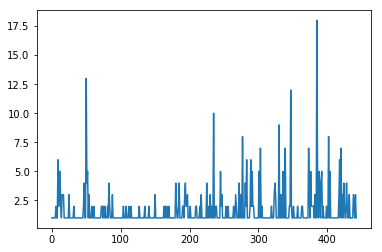

In [22]:
youngsReduced['numSamp'].plot()

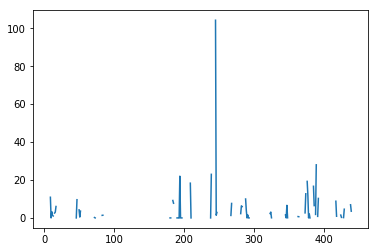

In [23]:
youngsReduced['E_std'].plot()

### Density Model Dataset
Use as benchmark for validity of other models?

In [30]:
densitySLAC = pd.DataFrame()
densitySLAC['comp'] = dfSLAC['comp']
densitySLAC['density'] = dfSLAC['density (g/cm3)']

densitySLAC.dropna(inplace=True)
densitySLAC.reset_index(drop=True, inplace=True)
densitySLAC = densitySLAC[[(type(x) in (int, float)) for x in densitySLAC['density']]]
densitySLAC['density'].astype(float)
densitySLAC.reset_index(drop=True, inplace=True)

In [31]:
print('dropping N/A, non number density values leaves {} values'.format(len(densitySLAC)))
densitySLAC.head()

dropping N/A, non number density values leaves 746 values


,comp,density
0,"(Ce, Al)",3.462
1,"(Al, Fe, B)",3.539
2,"(Zr, Al, Ni)",3.384
3,"(Zr, Al, Ni)",3.517
4,"(Hf, Al, Ni)",2.835


In [32]:
densityData = densitySLAC #.append(densityNREL, ignore_index=True)
print('{} = {} + {}?'.format(len(densityData), len(densitySLAC), len([])))

746 = 746 + 0?


In [35]:
# Drop exceptions actually accepted into composition object.... (T0+, M0+, glass0+)
print(densityData.loc[[94, 273, 326]])
densityData.drop([94, 273, 326], inplace=True)
densityData.reset_index(inplace=True, drop=True)

                      comp density
94   (T0+, Zr, Cu, Sn, Pd)    6.62
273          (M0+, Al, Cu)   6.564
326       (Glass0+, Si, O)     2.2


In [ ]:
%%time
X_dens = base_featurizer.featurize_many(densityData['comp'], ignore_errors=True)
X_dens = np.array(X_dens)
X_dens.astype(float)
print('Computed {} features'.format(X_dens.shape[1]))

In [ ]:
print(np.where(np.isnan(X_dens)))
featCleanImpute(X_dens)
print(np.where(np.isnan(X_dens)))

In [ ]:
X_dens_raw = base_featurizer.featurize_many(densityData['comp'], ignore_errors=True)

In [ ]:
iinf = set(np.where(np.isinf(X_dens_raw))[0])
print(len(iinf))
iinf

In [ ]:
ierror = inan.union(iinf)
X_dens_trim = np.delete(X_dens_raw, list(ierror), axis=0)
print(len(X_dens_trim))
densityDataTrim = densityData.drop(axis=0,index=list(ierror))
densityDataTrim.reset_index(drop=True, inplace=True)

In [ ]:
np.where(np.isinf(X_dens_trim))

In [ ]:
with gzip.open('./datasets/density_features.pkl.gz', 'wb') as fp:
    pkl.dump(X_dens_trim, fp)
with gzip.open('./datasets/density_data.pkl.gz', 'wb') as fd:
    pkl.dump(densityDataTrim, fd)

#### Generate Reduced Dataset with some stats

In [ ]:
%%time
densReduced = genStatsDF(densityData)
densReduced.head()

print('combining duplicates removes {} entries'.format(len(densityData)-len(densReduced)))

In [ ]:
densReduced['density_std'].plot()

In [ ]:
densReduced['numSamp'].plot()

In [ ]:
cnt=0

for x in densityData['comp']:
    print(x)
    cnt+=1
    if cnt==30:
        break